In [84]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def resection_with_2_known_points(point1, point2, measures_first_point, measures_second_point):
    station_z = ((point1[2] - measures_first_point[2]*np.cos(measures_first_point[0])) + (point2[2] - measures_second_point[2]*np.cos(measures_second_point[0])))/2
    
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = abs(measures_first_point[2]*np.sin(measures_first_point[0]))
    radius_2 = abs(measures_second_point[2]*np.sin(measures_second_point[0]))
    
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    y = (np.power(radius_1, 2) - np.power(radius_2, 2) - np.power(point1[1], 2) + np.power(point2[1], 2))/(2*delta_y)
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    A = 1
    B = -2*point1[0]
    C = np.power(point1[0], 2) + np.power(y, 2) + np.power(point1[1], 2) - 2*y*point1[1] - np.power(radius_1, 2)
    
    x_1 = (-B + np.sqrt(np.power(B, 2) - 4*A*C))/2*A
    
    x_2 = (-B - np.sqrt(np.power(B, 2) - 4*A*C))/2*A    
    
    # find the yaw offset to get the measures back in the prism's frame
    theta_station__prism_1 = np.arctan2(abs(point1[0]-x_1), radius_1)
    if (x_1 > point1[0]):
        yaw_1 =  (measures_first_point[1] - theta_station__prism_1 + np.pi/2)
    else:
        yaw_1 =  (measures_first_point[1] - theta_station__prism_1 + np.pi/2)
        
    theta_station__prism_2 = np.arctan2(abs(point1[0]-x_2), radius_2)
    if (x_2 > point1[0]):
        yaw_2 =  (measures_first_point[1] - theta_station__prism_2 + np.pi/2)
    else:
        yaw_2 =  (measures_first_point[1] - theta_station__prism_2 + np.pi/2)
        
    station_pos_complete_1 = np.array([x_1, y, station_z, 0, 0, yaw_1])    
    station_pos_complete_2 = np.array([x_2, y, station_z, 0, 0, yaw_2])
    
    return station_pos_complete_1, station_pos_complete_2

In [85]:
%matplotlib notebook

pilier_A = np.array([1000, 1000, 100])
pilier_B = np.array([1000, 1000 - np.sqrt(np.power(181.016, 2) - np.power(0.323, 2)), 100-0.323])
pilier_C = np.array([1000, 1000 - np.sqrt(np.power(363.492, 2) - np.power(1.038, 2)), 100-1.038])
pilier_D = np.array([1000, 1000 - np.sqrt(np.power(548.578, 2) - np.power(2.374, 2)), 100 - 2.374])

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
ttfu = importlib.reload(ttfu)

file_name = './data/total_station/20220630-1/theodolite_reference_prisms.txt'

raw_1, raw_2, raw_3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = ttfu.read_marker_file_raw_data(file_name)

station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_1[0], raw_1[1])

station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_2[0], raw_2[1])

station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_3[0], raw_3[1])
print("Sation 1:")
print("possible position 1: ", station_1_pos1)
print("possible position 2: ", station_1_pos2)
print("Station 2:")
print("possible position 1: ", station_2_pos1)
print("possible position 2: ", station_2_pos2)
print("Station 3:")
print("possible position 1: ", station_3_pos1)
print("possible position 2: ", station_3_pos2)

Sation 1:
possible position 1:  [1015.09249351  574.34548304   97.34519957    0.            0.
    4.64775486]
possible position 2:  [984.90750649 574.34548304  97.34519957   0.           0.
   4.53733206]
Station 2:
possible position 1:  [1014.29310913  573.71061516   97.64721333    0.            0.
    7.25798904]
possible position 2:  [985.70689087 573.71061516  97.64721333   0.           0.
   7.15517986]
Station 3:
possible position 1:  [1013.50790411  572.57282134   97.90734496    0.            0.
    5.69758201]
possible position 2:  [986.49209589 572.57282134  97.90734496   0.           0.
   5.60410988]


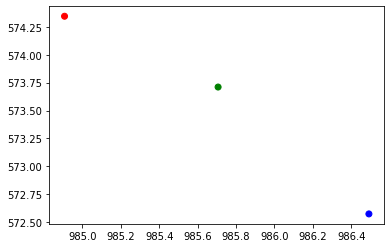

In [86]:
%matplotlib inline
plt.figure()
plt.scatter([station_1_pos2[0], station_2_pos2[0], station_3_pos2[0]],[station_1_pos2[1], station_2_pos2[1], station_3_pos2[1]],c=['r', 'g', 'b'])

Average error during the calibration:  2276.775 mm
TF1:  [[-1.74164192e-01  9.84716626e-01  0.00000000e+00  9.84907506e+02]
 [-9.84716626e-01 -1.74164192e-01  0.00000000e+00  5.74345483e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.73451996e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
TF2:  [[ 6.43300774e-01 -7.65613554e-01  0.00000000e+00  9.85706891e+02]
 [ 7.65613554e-01  6.43300774e-01  0.00000000e+00  5.73710615e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.76472133e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
TF3:  [[ 7.78153751e-01  6.28073833e-01  0.00000000e+00  9.86492096e+02]
 [-6.28073833e-01  7.78153751e-01  0.00000000e+00  5.72572821e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.79073450e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


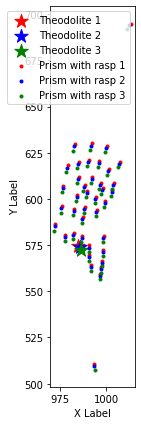

In [87]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
#TF1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1)
TF1 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2)

#TF2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1)
TF2 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2)

#TF3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1)
TF3 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2)

tp1 = TF1@trimble_1
tp2 = TF2@trimble_2
tp3 = TF3@trimble_3
tp1 = tp1.T
tp2 = tp2.T
tp3 = tp3.T

error = []
for i,j,k in zip(tp1,tp2,tp3):
    dist_12 = np.linalg.norm(i-j)
    dist_13 = np.linalg.norm(i-k)
    dist_23 = np.linalg.norm(k-j)
    error.append(dist_12)
    error.append(dist_13)
    error.append(dist_23)
print("Average error during the calibration: ", round(np.mean(error)*1000,3), "mm")
print("TF1: ", TF1)
print("TF2: ", TF2)
print("TF3: ", TF3)

tfu.plot_trajectories_prism(3, tp1.T, tp2.T, tp3.T, TF1, TF2, TF3, 0, 0,"example.pdf",1)